# “Lecture” 11- Finalizing Linear Regression
#### Peter Shaffery
#### 2/18/2021

## Multiple Linear Regression
### Introduction
Today I’d like to walk through a multiple linear regression model for a completely new dataset. Together, we will work through the main stages of data analysis:

<ol> 
    <li>Exploratory data analysis (EDA): understanding what’s in the datasets, determining if any variable transforms are obviously needed 
    <ol>
    <li>2a. Model selection: Determining which variables to include in our model</li> 
    <li>2b. Model diagnostics: Determine if our “first draft” model is any good, iterate on model selection and variable transforms accordingly</li>
    </ol>
<li> Final Regression: Perform our final regression, put together some final conclusions, make predictions if needed</li>
</ol>
This lecture will assume that you are following along at home with your own copy of the dataset. Please make sure that you download the <code>education.csv</code> dataset from Canvas before watching or reading through this lecture.

## EDA
For a working statistician or data scientist, it is often the case that the data under analysis was collected by someone else. While (in an ideal case) the data collector has direct input on the analysis, it is easy for both the collector and the statistician to overlook problems in the data that can seriously undermine the efficacy of a statistical analysis. Therefore, it’s good practice to begin any analysis with an Exploratory Data Analysis (abbreviated EDA). The purpose of EDA is to familiarize yourself with the contents of the dataset, and to check for problems before modeling stage. Questions we should be asking ourselves at this point include:
<ul>
    <li>What variables are available to model with?</li>
    <li>What relationships do we expect to exist between these variables?</li>
    <li>Are there any missing data points?</li>
    <li>Are there any obvious problems with any variable (nonsense values, constant or near-constant values, collinearity)?</li>
    </ul>
The data that we will be working with includes information on per capita education spending by state, as well as several other state-level predictor variables. We will be looking to construct a model of education spending in order to forecast future spending levels, based on expected trends in the predictor variables.

In [2]:
install.packages("car", repos = 'https://cran.r-project.org/web/packages/car/index.html')

Warning message:
“unable to access index for repository https://cran.r-project.org/web/packages/car/index.html/src/contrib:
  cannot open URL 'https://cran.r-project.org/web/packages/car/index.html/src/contrib/PACKAGES'”
Warning message:
“package ‘car’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [4]:
library(tidyverse)
library(magrittr)
library(broom)

educ = read.csv("education.csv")
educ %>% head

,state,educ,income,youth,urban,region,gdp,tax,wls.weights
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,ME,235,39440,325,508,1,161421,233,0.00066169
2,NH,231,45780,323,564,1,195522,16,0.00066169
3,VT,270,40110,328,322,1,171952,294,0.00066169
4,MA,261,52330,305,846,1,239147,582,0.00066169
5,RI,300,47800,303,871,1,198699,253,0.00066169
6,CT,317,58890,307,774,1,271263,544,0.00066169


In [5]:
# we don't the wls.weights variable for now, so drop it
educ %<>% select(-wls.weights)

The data columns are defined as follows:

| Variable | Definition |
| --- | --- | 
| STATE | Two-letter state code |
| EDUC | Per-capita education expenditure (USD per-cap) |
| INCOME | Median personal income of state residents (USD) |
| YOUTH | Number of residents below the age of 18 (thousands of people) |
| URBAN | Number of residents living in a Census-defined "urban area" (thousands of people) |
| REGION | Census-defined region of the US |
| GDP | Per-capita state gross product (USD per-cap) |
| TAX | Per-capita income tax revenue (USD per-cap) |

We see that, aside from STATE and EDUC, the data contains two general types of variable: economic measures (INCOME, GDP, and TAX), and demographic measures (YOUTH, URBAN).
<br>
Please try and answer the following questions. I’ll give you a five minute head start and then will begin to work through my approach.
<ol>
    <li>Are there any missing data points?</li>
    <li>Which variables (if any) are collinear?</li>
    </ol>

## Missing Data Points
This is a quick R one-liner:

In [6]:
educ %>% is.na %>% any

[1] FALSE

## Collinearity

In [7]:
# Already I know I want to exclude the STATE, it has very high cardinality and is redundant against REGION 
mod.dat = educ %>% select(-state)

cor(mod.dat)

,educ,income,youth,urban,region,gdp,tax
educ,1.0000000,0.6083027,0.2684302,0.322115988,0.156452895,0.5582985,0.538676438
income,0.6083027,1.0000000,-0.2970364,0.621936720,-0.200324803,0.7972328,0.650075603
youth,0.2684302,-0.2970364,1.0000000,-0.286520057,0.441022226,-0.1311301,-0.211486153
urban,0.3221160,0.6219367,-0.2865201,1.000000000,-0.006018559,0.4934802,0.418760471
region,0.1564529,-0.2003248,0.4410222,-0.006018559,1.000000000,-0.2231086,-0.006194682
gdp,0.5582985,0.7972328,-0.1311301,0.493480174,-0.223108577,1.0000000,0.693360002
tax,0.5386764,0.6500756,-0.2114862,0.418760471,-0.006194682,0.6933600,1.000000000


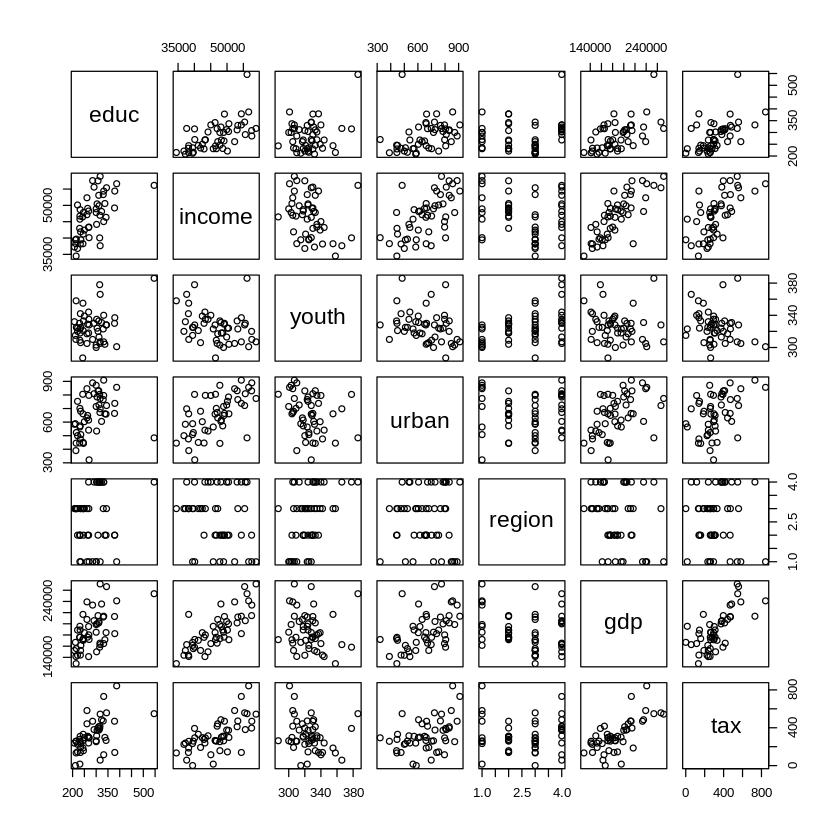

In [8]:
pairs(mod.dat) # looks like there may be some heteroskedasiticity...

In [9]:
vif(lm(educ~.,data=mod.dat%>% mutate('region'=as.factor(region))))

ERROR: Error in vif(lm(educ ~ ., data = mod.dat %>% mutate(region = as.factor(region)))): could not find function "vif"


## Conclusions
The economic variables all exhibit some degree of correlation, which is reasonable (INCOME and TAX in particular, we should expect to the closely related overall). This suggests that we might be worried about how colinearity will impact our model However, looking at the VIF it doesn’t appear to quite meet the threshold for automatic removal. Nevertheless, we might expect that during the model selection process at least one of these variables will likely be cut.



## Model Selection and Diagnosis
Now that we have some idea of what exists in our dataset, we’re ready to begin modeling. As we have seen, modeling is generally done iteratively. That is, the analyst begins with some base model which acts as a starting point, and then makes changes to either the base model or the data in order to resolve issues with the regression or to improve the model performance.
<br>
Whether your goal is inference or prediction, statistical modeling is never “automatic” and always requires the analyst to make decisions. It is therefore important to present your results in the context of those decision as much as possible.Presenting just the final regression table can be misleading when those numbers are the result of an iterative decision process.
<br>
For this example, we have two goals. We would like to produce a model which will perform well predictively, and thus we need to choose our variables carefully. Furthermore, from the EDA we suspect that heteroskedasticity might be present. We therefore need to design our model to address both of these concerns, as well as be on the lookout for problems which didn’t show up in the EDA.
<br>
Let’s start by fitting a model which includes every variable (in R educ ~ .). Please use this model to answer the following questions. I’ll give you a five minute head start and then will begin to work through my approach.
<ol>
    <li>What coefficients are significant? Do you trust those p-values?</li>
    <li>Which regression assumptions are met, and which are not met, by the data?</li>
    <li>Are any outliers present in the data?</li>


## Checking Assumptions

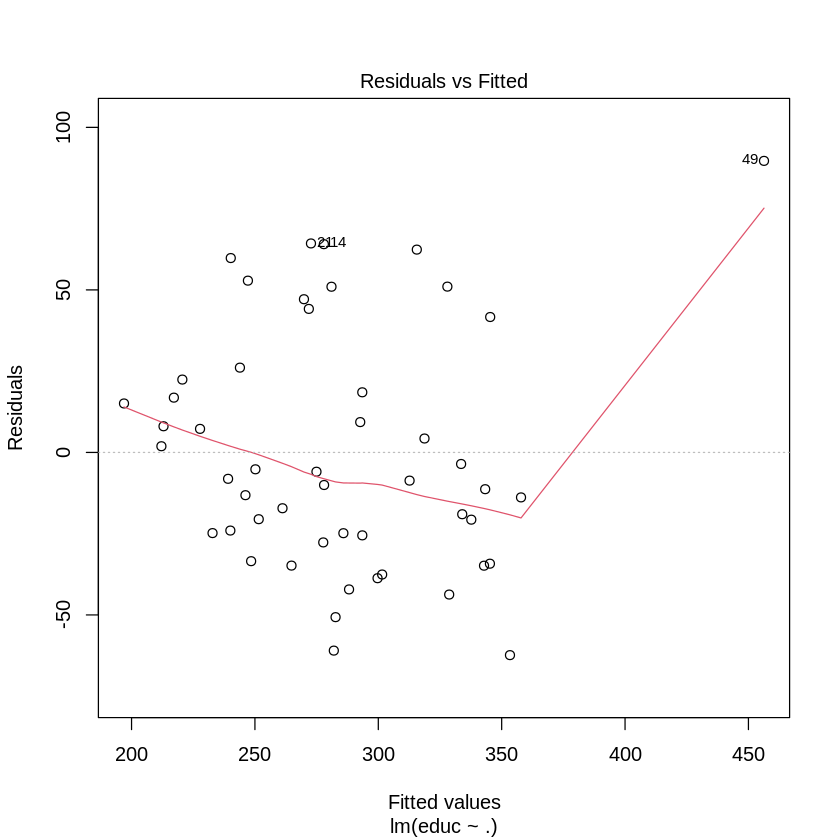

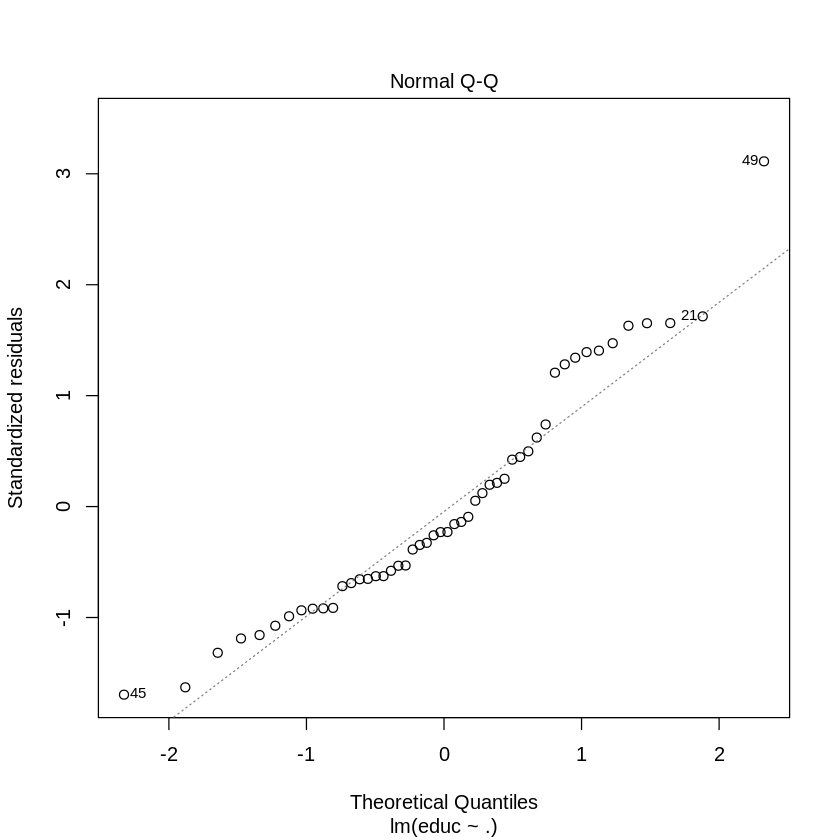

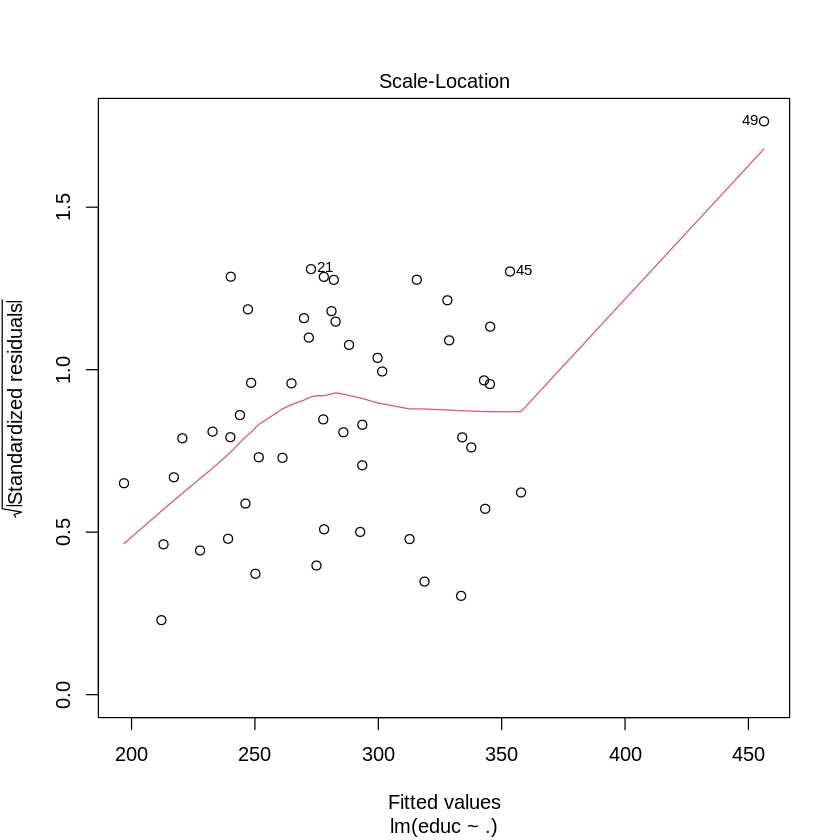

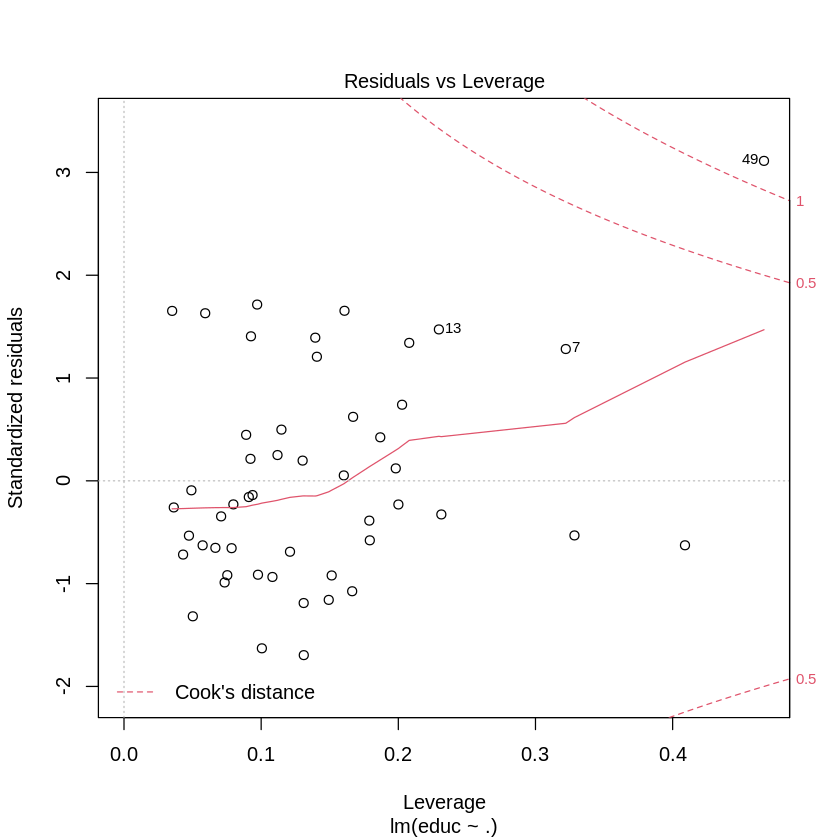

In [10]:
full.mod = lm(educ~., data=mod.dat)
plot(full.mod)

## Outliers

In [11]:
mod.dat = mod.dat[-49,]

full.mod = lm(educ~., data=mod.dat%>%mutate('region'=as.factor(region)))
summary(full.mod)



Call:
lm(formula = educ ~ ., data = mod.dat %>% mutate(region = as.factor(region)))

Residuals:
   Min     1Q Median     3Q    Max 
-62.83 -19.53  -5.60  24.85  73.93 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -1.469e+02  1.525e+02  -0.963   0.3411  
income       2.964e-03  2.032e-03   1.459   0.1525  
youth        7.317e-01  3.856e-01   1.897   0.0650 .
urban        5.663e-02  5.192e-02   1.091   0.2819  
region2      2.817e+00  1.808e+01   0.156   0.8770  
region3     -1.533e+01  1.634e+01  -0.938   0.3541  
region4      1.298e+01  1.920e+01   0.676   0.5028  
gdp         -6.799e-05  3.182e-04  -0.214   0.8319  
tax          8.619e-02  4.557e-02   1.891   0.0659 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.71 on 40 degrees of freedom
Multiple R-squared:  0.5797,	Adjusted R-squared:  0.4956 
F-statistic: 6.896 on 8 and 40 DF,  p-value: 1.135e-05


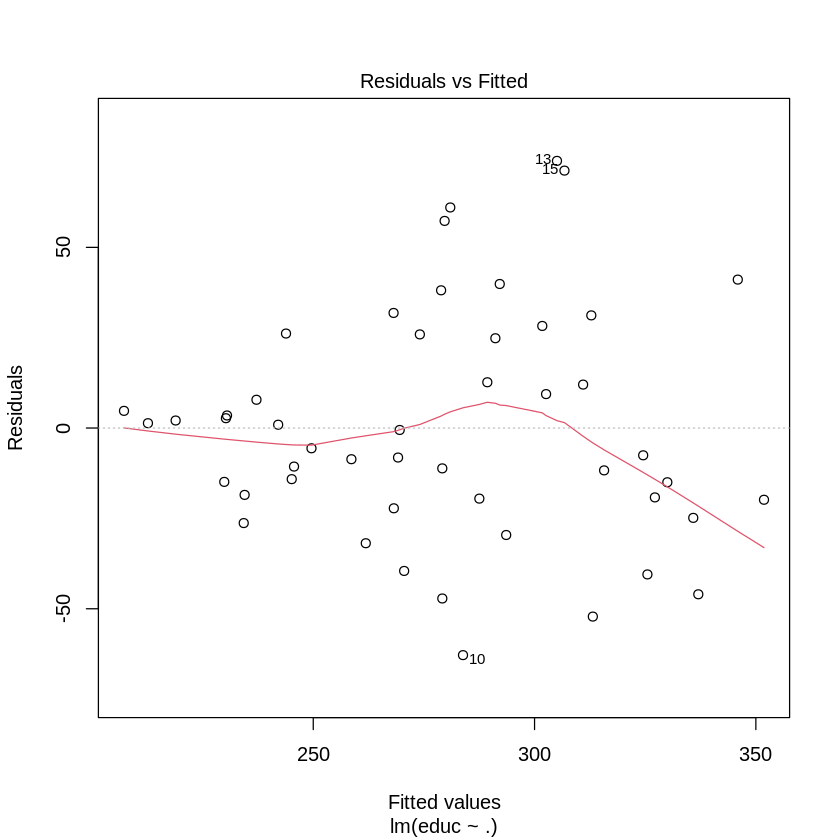

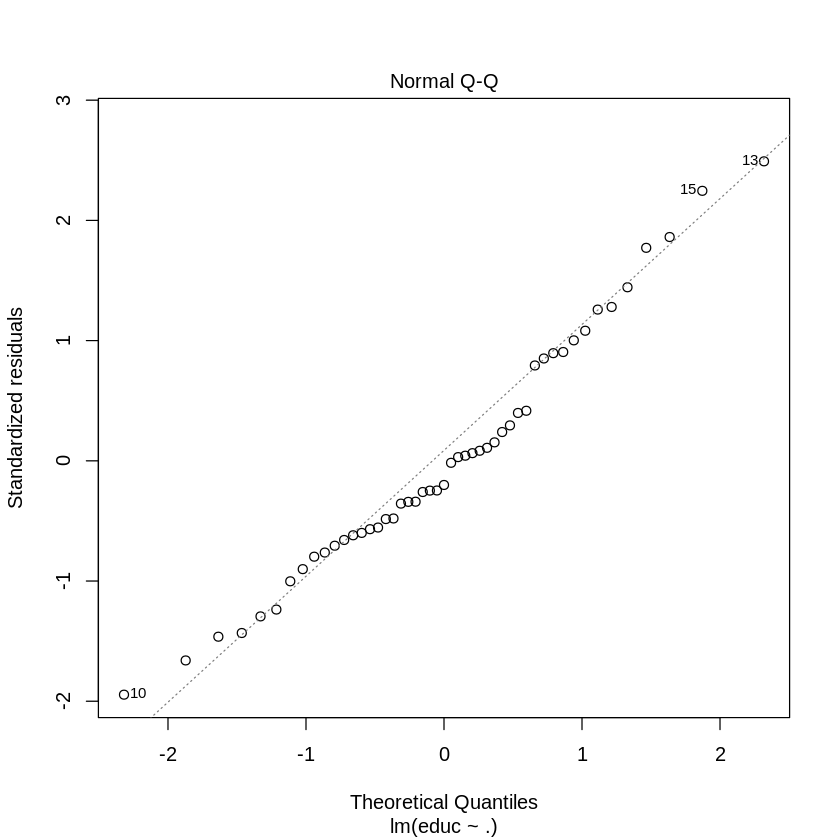

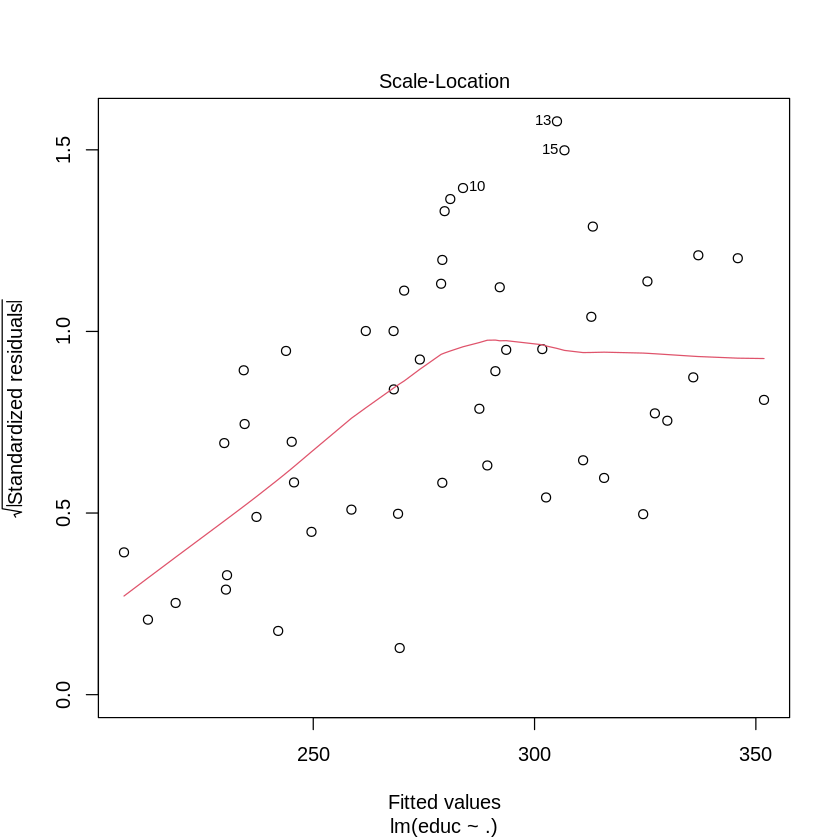

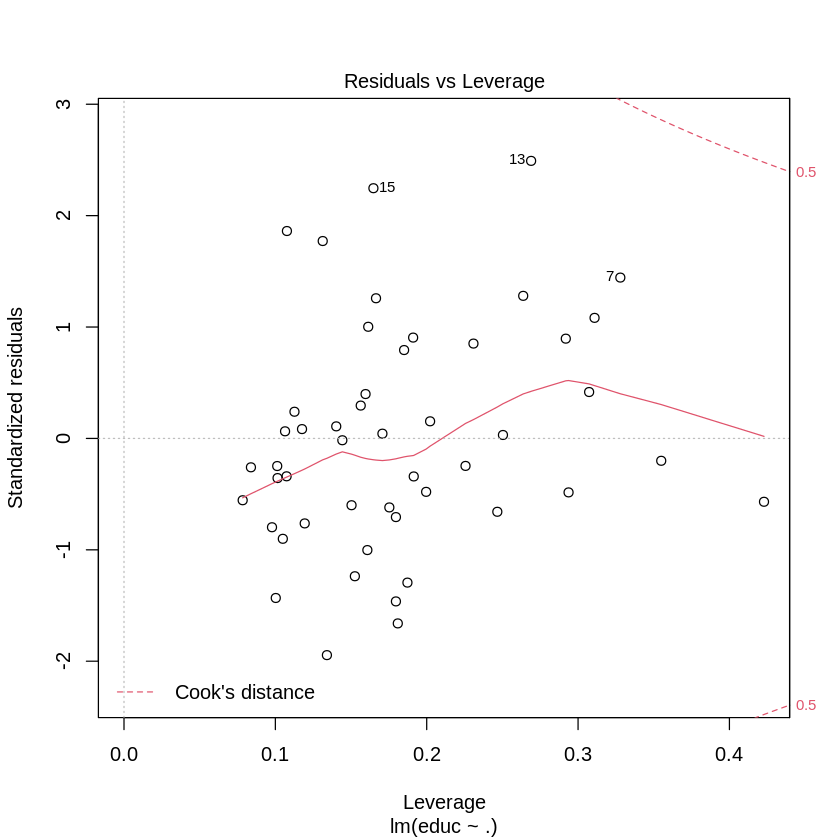

In [12]:
plot(full.mod)

## Intermezzo: Weighted Least Squares
Last lecture we saw an example where we performed weighted least squares by writing the variance $Var[ϵ_i]$ as a function of $x_i$ explicitly (we had said that $ Var[ϵ_i]=x^{2}_i)$. This allowed us to calculate the data weights using this function.
<br>
<br>
In many cases, however, it is challenging to figure out the exact relationship between $Var[ϵ_i]$ and the $x_{ij}$. Therefore, it is common practice to calculate weights by *binning* the data points by similar values of $x_{ij}$, and calculating the sample variance of the residuals within each bin. This is what we will do here.
<br>
<br>
First, we need to pick a variable that we think drive the *most* heteroskedasticity. To do this, we will make another pairs plot but replace the dependent variable EDUC with the residuals from our full model. This will help us understand which variables cause the most dramatic heteroskedasticity in the final model:

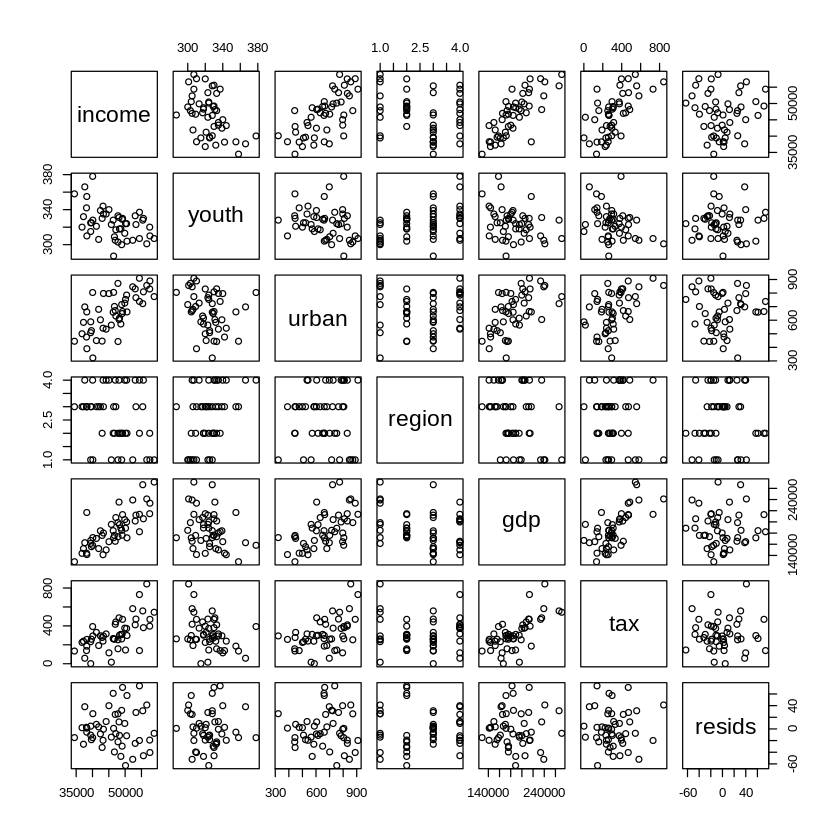

In [13]:
mod.dat['resids'] = full.mod %>% augment %>% select('.resid')
pairs(mod.dat%>%select(-educ))

We see grouping the data by REGION leads to very different values for $Var[ϵ_i]$. We will therefore estimate residual variance at the REGION-level, and use this to calculate our model weights.

In [14]:
mod.dat %<>% group_by(region) %>%
  mutate(wls.weights = 1/var(resids)) %>%
  ungroup

full.mod = lm(educ~youth+region+income+gdp+tax,
              data=mod.dat%>%mutate('region'=as.factor(region)),
              weights = wls.weights)
summary(full.mod)


Call:
lm(formula = educ ~ youth + region + income + gdp + tax, data = mod.dat %>% 
    mutate(region = as.factor(region)), weights = wls.weights)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-2.14913 -0.65008 -0.06939  0.71786  1.76992 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.858e+02  9.667e+01  -1.922  0.06158 . 
youth        6.663e-01  2.330e-01   2.860  0.00664 **
region2      1.268e-01  1.974e+01   0.006  0.99491   
region3     -6.694e+00  1.267e+01  -0.528  0.60022   
region4      2.213e+01  1.532e+01   1.445  0.15606   
income       4.678e-03  1.324e-03   3.533  0.00103 **
gdp          6.308e-05  1.920e-04   0.328  0.74424   
tax          5.095e-02  3.358e-02   1.517  0.13686   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.015 on 41 degrees of freedom
Multiple R-squared:  0.7984,	Adjusted R-squared:  0.764 
F-statistic: 23.19 on 7 and 41 DF,  p-value: 2.276e-12


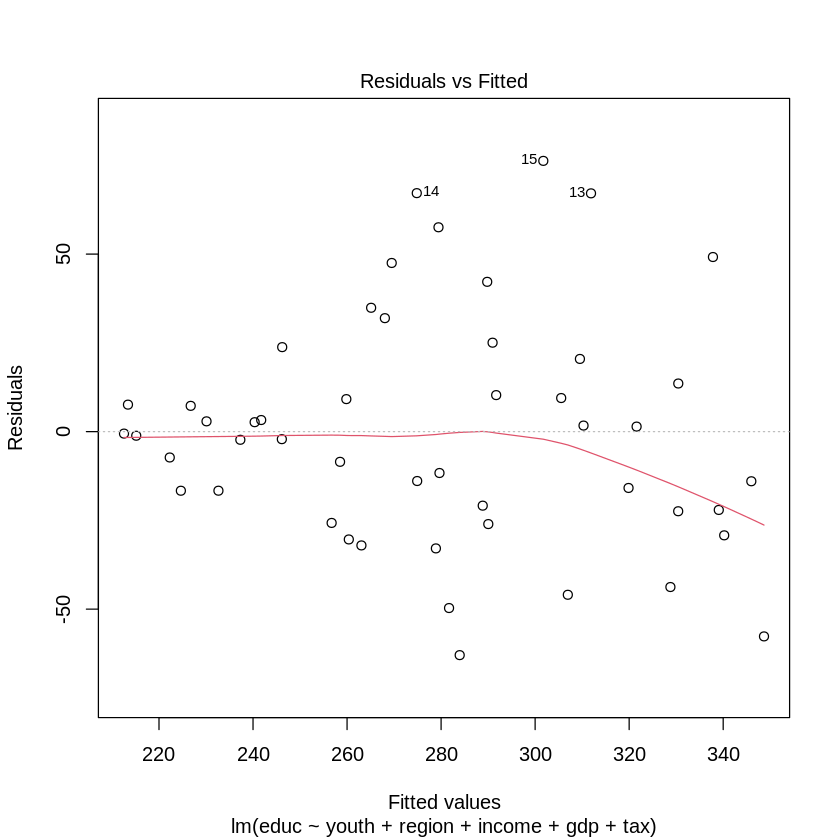

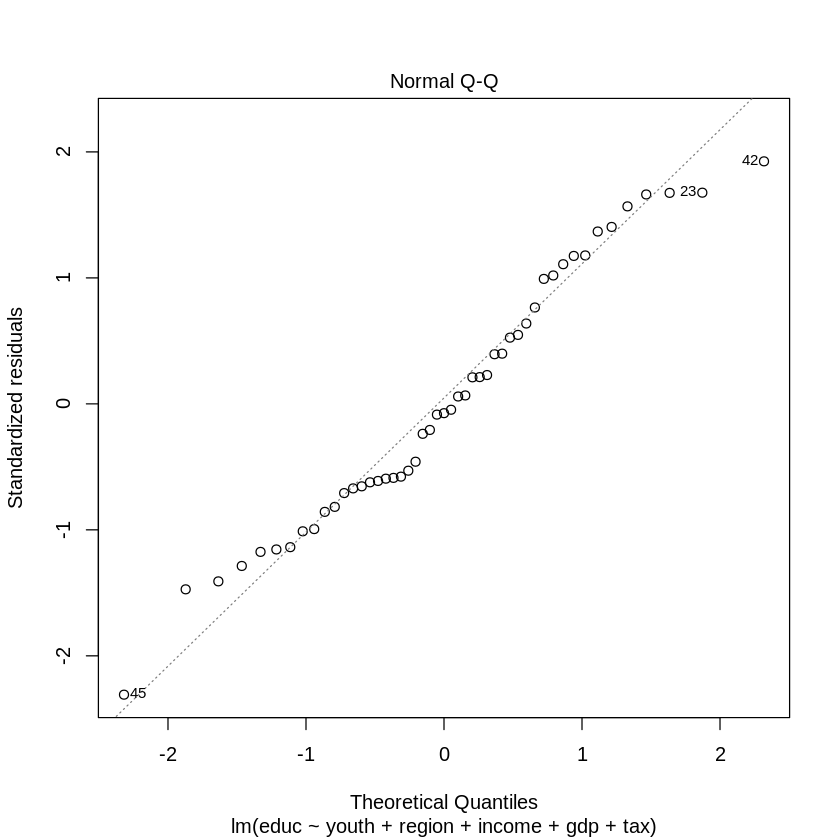

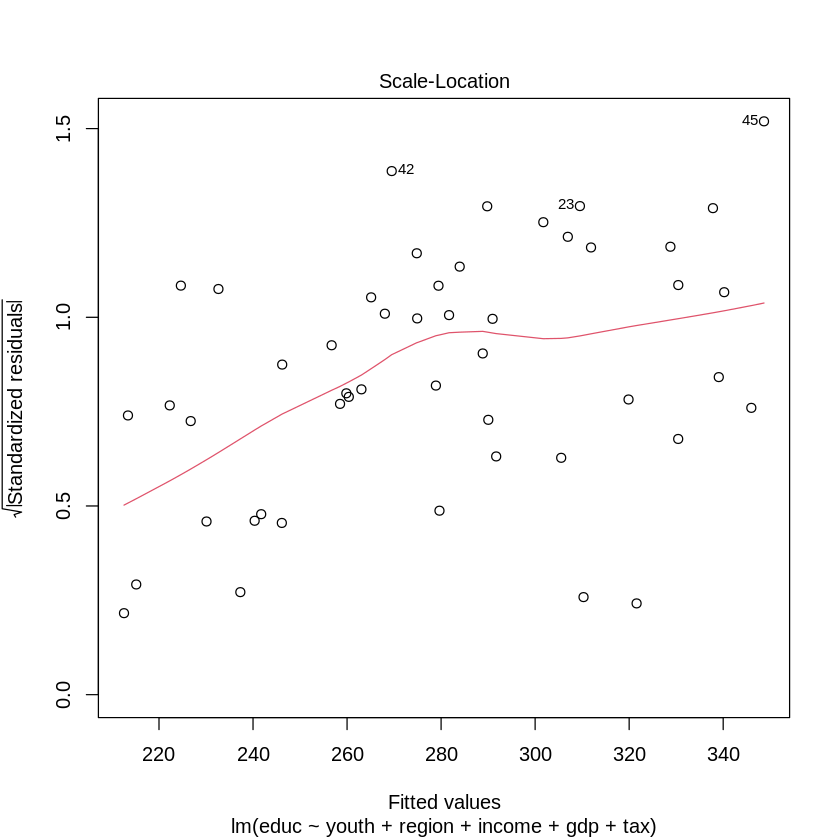

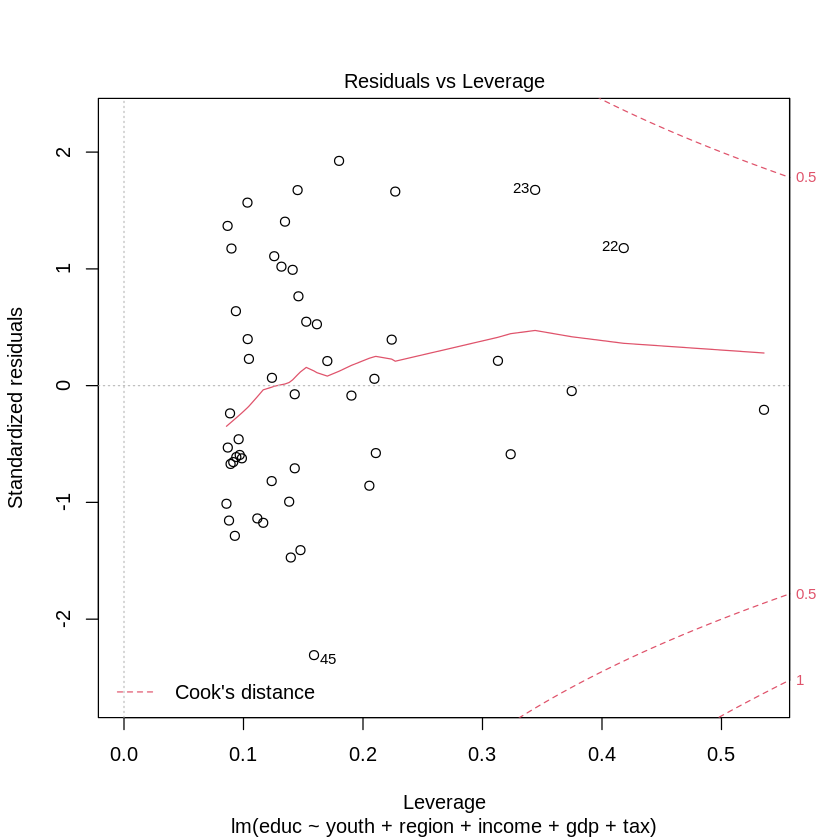

In [15]:
plot(full.mod)

## Model Selection and Diagnosis (con’t)
Now that we have properly weighted our data points and the diagnostics look good, we can get started with our variable selection. In general, you want your model diagnostics to be correct *before* beginning variable selection, as problems like heteroskedasticity can negatively influence your model quality metric.
<br>
<br>
Because our final goal is prediction, let’s use the AIC to find a model which balances model fit with complexity. Models with too many variables can be *overfit*, that is their performance on the observed data will be substantially better than on out-of-sample data. We therefore are willing to sacrifice a little bit of a low in-sample error rate if it allows us to strike a variable.
<br>
<br>
Let’s say that, through our domain knowledge in education policy, we know for sure that we want to include YOUTH in our model. Please use the AIC to answer the following questions. I’ll give you a five minute head start before going through my solution:
<ol>
<li>Which economic variable(s) (INCOME, TAX, and/or GDP, if any) should be included in the model?</li>
<li>Which demographic variable(s) (URBAN and/or REGION, if any) should be included in the model?</li>
    </ol>

## Economic Variables

In [16]:
get.aic = function(m){ m %>% glance %>% select(AIC) %>% return }
mod.dat$region %<>% as.factor

mod.none = lm(educ~youth,data=mod.dat,weight=wls.weights)
mod.inc = lm(educ~youth+income,data=mod.dat,weight=wls.weights)
mod.gdp = lm(educ~youth+gdp,data=mod.dat,weight=wls.weights)
mod.tax = lm(educ~youth+tax,data=mod.dat,weight=wls.weights)
mod.all.econ = lm(educ~youth+income+gdp+tax,data=mod.dat,weight=wls.weights)

mod.none %>% get.aic

AIC
<dbl>
538.7703


In [17]:
mod.inc %>% get.aic

AIC
<dbl>
473.2961


In [18]:
mod.gdp %>% get.aic

AIC
<dbl>
508.4844


In [19]:
mod.tax %>% get.aic

AIC
<dbl>
506.0697


In [20]:
mod.all.econ %>% get.aic

AIC
<dbl>
474.3188


## Demographic Variables

In [21]:
get.aic = function(m){ m %>% glance %>% select(AIC) %>% return }

mod.none = lm(educ~youth+income,data=mod.dat,weight=wls.weights)
mod.urb = lm(educ~youth+income+urban,data=mod.dat,weight=wls.weights)
mod.reg = lm(educ~youth+income+region,data=mod.dat,weight=wls.weights)
mod.both = lm(educ~youth+income+urban+region,data=mod.dat,weight=wls.weights)

mod.none %>% get.aic

AIC
<dbl>
473.2961


In [22]:
mod.urb %>% get.aic

AIC
<dbl>
474.4066


In [23]:
mod.reg %>% get.aic

AIC
<dbl>
471.3542


In [24]:
mod.both %>% get.aic

AIC
<dbl>
473.0566


## Conclusions
Based on this we conclude that our best model if <code>educ~youth+income+reg</code>. Note that this result is really to our use of WLS. Look what happens if we *don’t* use the weights:

In [25]:
mod.inc = lm(educ~youth+income,data=mod.dat)
mod.all.econ = lm(educ~youth+income+gdp+tax,data=mod.dat)

mod.inc %>% get.aic

AIC
<dbl>
495.5


In [26]:
mod.all.econ %>% get.aic

AIC
<dbl>
494.2423


We would have chosen an entirely different model! If we had done variable selection before model diagnostics, it would have been important to re-run the selection process after having accounted for the outliers and heteroskedasticity.

## Final Regression
Now that we’ve corrected our model assumption violations and chosen a model form, it’s time to summarize our results. Besides giving you a paper to publish, reading through your results and translating them back into plain English (or other language) is an important final sanity-check to make sure nothing has gone wrong unnoticed.
<br>
<br>
Here you should be looking to answer questions like:
<ul>
    <li>Which variables are the most important? Does this make sense?</li>
    <li>Are any coefficient values particularly surprising or nonsensical?</li>
    </ul>
**NOTE**: this does not mean that you should try and “correct” a result that you do not like. Just because your scientific hypothesis was not confirmed doesn’t mean that the result is nonsensical. Nevertheless, there are cases where ex. your regression results contradict a strongly established result. In these cases you should be extra careful that none of your diagnostic correction, outlier omissions, etc. are not solely responsible for this new result. You may have discovered something hitherto unknown! But you also may have just biffed your R code.
<br>
<br>
Using the model <code>educ~youth+income</code> please answer the following question:
<ol>
    <li>How much variance is explained by your model?</li>
    <li>Which variable (YOUTH or INCOME) “matters more” to your model?</li>

## Variance Explained

In [27]:
mod.final = lm(educ~youth+income+region, data=mod.dat, weights=wls.weights)
mod.final %>% summary


Call:
lm(formula = educ ~ youth + income + region, data = mod.dat, 
    weights = wls.weights)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-2.46916 -0.68731 -0.03738  0.77624  1.97098 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.427e+02  8.203e+01  -2.958 0.005013 ** 
youth        7.332e-01  2.034e-01   3.604 0.000807 ***
income       6.068e-03  6.224e-04   9.750 1.85e-12 ***
region2     -7.280e+00  1.888e+01  -0.386 0.701686    
region3     -5.486e+00  1.272e+01  -0.431 0.668282    
region4      2.059e+01  1.442e+01   1.428 0.160647    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.023 on 43 degrees of freedom
Multiple R-squared:  0.7854,	Adjusted R-squared:  0.7605 
F-statistic: 31.48 on 5 and 43 DF,  p-value: 2.461e-13


## Variable Importance

In [28]:
center.scale = function(x){ (x-mean(x))/sd(x) }
mod.dat['educ.cs'] = center.scale(mod.dat$educ)
mod.dat['youth.cs'] = center.scale(mod.dat$youth)
mod.dat['income.cs'] = center.scale(mod.dat$income)

mod.final.cs = lm(educ.cs~youth.cs+income.cs+region, data=mod.dat, weights=wls.weights)
mod.final.cs %>% summary


Call:
lm(formula = educ.cs ~ youth.cs + income.cs + region, data = mod.dat, 
    weights = wls.weights)

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.050524 -0.014064 -0.000765  0.015883  0.040330 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.03004    0.23719  -0.127 0.899818    
youth.cs     0.26326    0.07304   3.604 0.000807 ***
income.cs    0.79054    0.08108   9.750 1.85e-12 ***
region2     -0.14896    0.38630  -0.386 0.701686    
region3     -0.11226    0.26018  -0.431 0.668282    
region4      0.42129    0.29512   1.428 0.160647    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02093 on 43 degrees of freedom
Multiple R-squared:  0.7854,	Adjusted R-squared:  0.7605 
F-statistic: 31.48 on 5 and 43 DF,  p-value: 2.461e-13


## Conclusion
We see here that INCOME is *three times* more influential on EDUC than YOUTH. Our model is saying that in the future we should expect changes in a state’s median income to be the biggest drivers of changes in its educational spending.